# **Sarcasm Classification: Visualising Embedding Space after Contrastive Learning (Part 4)**

**Author: Shanmugam Udhaya**

*Contact:* [@frostbitepillars](https://t.me/frostbitepillars) for any clarifications  

---

In Part 3, we decided to focus on using contrastive learning to fine tune our BERT's CLS tokens and concatenating with our GloVe and Linguistic features as per normal. We saw potential to increase our F1 score to 0.927.

## **Visualization**

In this notebook, we aim to visualize the [CLS] embedding space to better understand the impact of contrastive fine-tuning. By plotting the embeddings, we hope to observe how samples of similar or different classes are pulled closer together or pushed apart — offering insights into how contrastive learning shapes the representation space.

## **t-SNE**

 t-distributed Stochastic Neighbor Embedding (t-SNE) is a dimensonality reduction technique which maps embeddings from its high dimensionality into 2 or 3 dimensions while preserving local structure.

It does so by using KL divergence to minimise divergence between probability distributions in the higher and lower dimensions. By doing so points that are close in the original distribution remain close in the lower dimension distribution.

This makes it especially useful for visualizing clustering or separation between classes after fine-tuning.



## Load Data

In [1]:
import pandas as pd
import numpy as np
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel # Use AutoModel for hidden states
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

In [3]:
from tqdm import tqdm

In [4]:
!gdown 1eVjlFhPvpgXmj-wH52qAzdIUyHrfs92G

Downloading...
From: https://drive.google.com/uc?id=1eVjlFhPvpgXmj-wH52qAzdIUyHrfs92G
To: /content/archive (7).zip
100% 3.46M/3.46M [00:00<00:00, 22.7MB/s]


In [5]:
!unzip "archive (7).zip"

Archive:  archive (7).zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


In [6]:
import pandas as pd

df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [7]:
print(df.columns)
print(df.isnull().sum())
print(Counter(df['is_sarcastic']))
print(df.head(10))

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')
is_sarcastic    0
headline        0
article_link    0
dtype: int64
Counter({0: 14985, 1: 13634})
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   
5             0                               my white inheritance   
6             0         5 ways to file your taxes with less stress   
7             1  richard branson's global-warming donation near...   
8             1  shadow government getting too large to meet in...   
9             0                 lots of parents know this scenario   

                                        article_link  
0  https:

## Pre-Processing

### No Pre-Processing at all

In [8]:
df['clean_headline'] = df['headline']

### With Pre-Processing

In [9]:
def preprocess_text(text, action, stopword):
  #Lower Caps
  #text = text.lower()
  #Remove Punctuations
  #text = text.translate(str.maketrans('', '', string.punctuation))

  #https://www.geeksforgeeks.org/text-preprocessing-for-nlp-tasks/
    # text = text.lower()  # Lowercase
  #text = re.sub(r'\d+', '', text)  # Remove numbers
    #text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
  #text = re.sub(r'\W', ' ', text)  # Remove special characters
    # text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
  # Tokenize and remove stopwords
  words = word_tokenize(text)
  if stopword:
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

  #If stemming
  if action == "S":
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
  elif action == "L":
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
  return " ".join(words)

# Apply preprocessing to the text column
df['clean_headline'] = df['headline'].apply(lambda text: preprocess_text(text, "", False))

## Linguistic Features from (feature eng1)

In [10]:
def get_pos_counts(text):
    """
    Returns a dictionary with counts of certain POS tags (NOUN, VERB, ADJ, ADV)
    """
    pos_tags = pos_tag(word_tokenize(text))
    counts = {
        'noun_count': 0,
        'verb_count': 0,
        'adj_count': 0,
        'adv_count': 0
    }
    for word, tag in pos_tags:
        if tag.startswith('NN'):
            counts['noun_count'] += 1
        elif tag.startswith('VB'):
            counts['verb_count'] += 1
        elif tag.startswith('JJ'):
            counts['adj_count'] += 1
        elif tag.startswith('RB'):
            counts['adv_count'] += 1
    return counts

def get_text_length(text):
    return len(word_tokenize(text))

import spacy
nlp = spacy.load("en_core_web_sm")

def get_ner_count(text):
    doc = nlp(text)
    return len(doc.ents)

In [11]:
df['pos_counts'] = df['clean_headline'].apply(get_pos_counts)
df['text_length'] = df['clean_headline'].apply(get_text_length)

df['noun_count'] = df['pos_counts'].apply(lambda x: x['noun_count'])
df['verb_count'] = df['pos_counts'].apply(lambda x: x['verb_count'])
df['adj_count'] = df['pos_counts'].apply(lambda x: x['adj_count'])
df['adv_count'] = df['pos_counts'].apply(lambda x: x['adv_count'])

In [12]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.2 MB/s eta 0:00:00


In [13]:
import textstat
df['flesch_reading_ease'] = df['clean_headline'].apply(lambda text: textstat.flesch_reading_ease(text))
df['dale_chall_score'] = df['clean_headline'].apply(lambda text: textstat.dale_chall_readability_score(text))

In [14]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['clean_headline'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

In [16]:
def count_chars(text):
    return len(text)

def count_words(text):
    return len(text.split())

def count_capital_chars(text):
  count=0
  for i in text:
    if i.isupper():
      count+=1
  return count

def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

def count_unique_words(text):
    return len(set(text.split()))

def count_exclamation(text):
    return text.count("!")

df['char_count'] = df['clean_headline'].apply(count_chars)
df['capital_char_count'] = df["clean_headline"].apply(lambda x:count_capital_chars(x))
df['capital_word_count'] = df["clean_headline"].apply(lambda x:count_capital_words(x))

In [17]:
df['stopword_count'] = df['clean_headline'].apply(lambda x: len([word for word in x.split() if word in stopwords.words('english')]))
df['word_count'] = df['clean_headline'].apply(count_words)
df['stopwords_vs_words'] = df['stopword_count']/df['word_count']

In [18]:
def has_contrastive_conjunction(text):
    contrastive_words = {"but", "although", "yet", "however", "though"}
    return int(any(word in text.split() for word in contrastive_words))

df['contrastive_marker'] = df['clean_headline'].apply(has_contrastive_conjunction)

In [19]:
import numpy as np
import pandas as pd
import textstat
import string
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from textblob import TextBlob
from scipy.stats import entropy

nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
from scipy.stats import entropy
def calculate_entropy(text):
    words = word_tokenize(text.lower())
    freq_dist = Counter(words)
    probs = np.array(list(freq_dist.values())) / sum(freq_dist.values())
    return entropy(probs, base=2)  # Shannon Entropy

df["entropy"] = df["clean_headline"].apply(calculate_entropy)

### 2. **Lexical Diversity (Unique Words / Total Words)**
def lexical_diversity(text):
    words = word_tokenize(text.lower())
    return len(set(words)) / len(words) if len(words) > 0 else 0

df["lexical_diversity"] = df["clean_headline"].apply(lexical_diversity)

### 6. **Wrong Words (Words Not in WordNet)**
def count_wrong_words(text):
    words = word_tokenize(text.lower())
    return sum(1 for word in words if not wordnet.synsets(word))

df["wrong_word_count"] = df["clean_headline"].apply(count_wrong_words)

### 7. **Difficult Words (Hard-to-Read Words)**
df["difficult_word_count"] = df["clean_headline"].apply(textstat.difficult_words)

### 8. **Lengthy Words (Words > 2 Characters)**
df["lengthy_word_count"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) > 2))

### 9. **Two-Letter Words**
df["two_letter_words"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) == 2))

### 10. **Single-Letter Words**
df["single_letter_words"] = df["clean_headline"].apply(lambda words: sum(1 for word in words if len(word) == 1))


In [21]:
def detect_incongruity(text):
    tokens = word_tokenize(text)
    pos_words = 0
    neg_words = 0

    for word in tokens:
        score = analyzer.polarity_scores(word)['compound']
        if score >= 0.5:
            pos_words += 1
        elif score <= -0.5:
            neg_words += 1

    # Return 1 if both positive and negative words exist → sentiment conflict
    return int(pos_words > 0 and neg_words > 0)

# Apply to the DataFrame
df['sentiment_incongruity'] = df['clean_headline'].apply(detect_incongruity)

In [22]:
None+1

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

## BERT CLS w/ TripletLoss

Loaded data with 28619 samples.
Class distribution:
is_sarcastic
0    0.523603
1    0.476397
Name: proportion, dtype: float64

Splitting data into train/test sets...
Train set size: 21464, Test set size: 7155

Loading tokenizer and base BERT model: bert-base-uncased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Using device: cuda

Generating BERT [CLS] embeddings BEFORE fine-tuning (for visualization)...
  Generating embeddings for 7155 texts in batches of 32...
    Processed batch 50/224 (22.3%) | ETA: 32.7s
    Processed batch 100/224 (44.6%) | ETA: 22.8s
    Processed batch 150/224 (67.0%) | ETA: 13.5s
    Processed batch 200/224 (89.3%) | ETA: 4.4s
    Processed batch 224/224 (100.0%) | ETA: 0.0s
  Finished generating embeddings in 40.93s.
BERT [CLS] TEST embeddings BEFORE fine-tuning shape: (7155, 768)

Preparing for contrastive fine-tuning...

--- Starting Contrastive Fine-tuning ---

Epoch 1/3
  Batch 50/671 | Loss: 0.3084 | LR: 1.49e-05
  Batch 100/671 | Loss: 0.2134 | LR: 1.97e-05
  Batch 150/671 | Loss: 0.1106 | LR: 1.91e-05
  Batch 200/671 | Loss: 0.1217 | LR: 1.86e-05
  Batch 250/671 | Loss: 0.2636 | LR: 1.81e-05
  Batch 300/671 | Loss: 0.1952 | LR: 1.76e-05
  Batch 350/671 | Loss: 0.1324 | LR: 1.71e-05
  Batch 400/671 | Loss: 0.1622 | LR: 1.66e-05
  Batch 450/671 | Loss: 0.2058 |

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.134974
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.757385
[t-SNE] KL divergence after 300 iterations: 1.944294
t-SNE finished for 'before' embeddings.


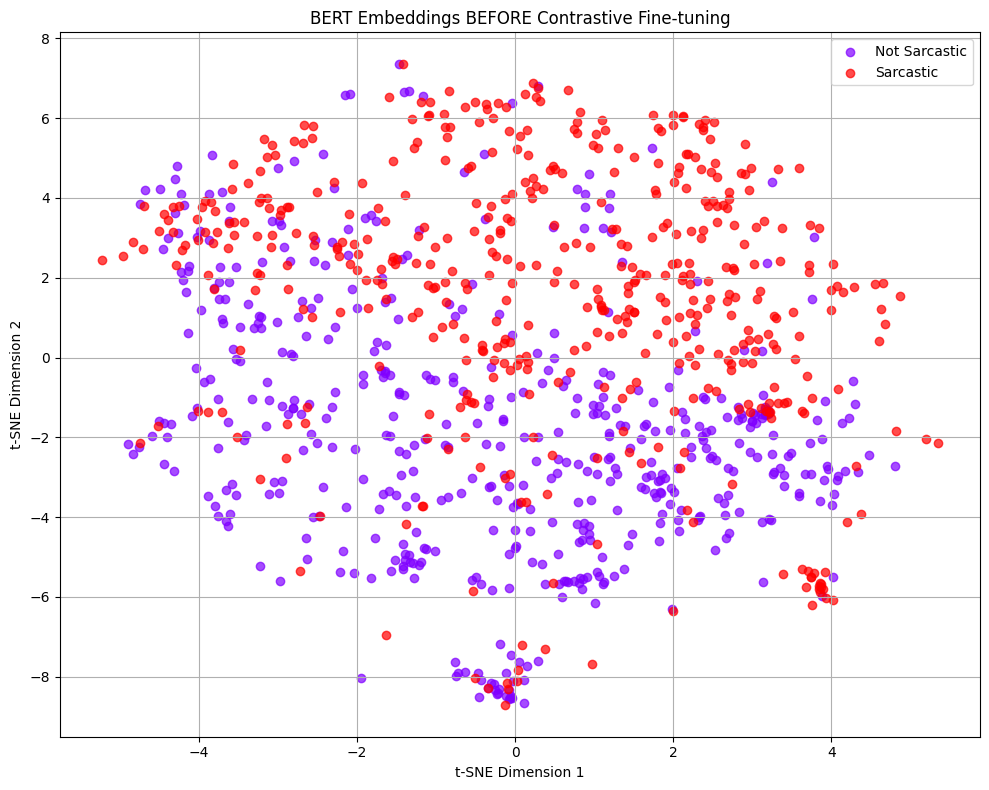


Running t-SNE on embeddings AFTER fine-tuning...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.947435


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.171539
[t-SNE] KL divergence after 300 iterations: 1.561743
t-SNE finished for 'after' embeddings.


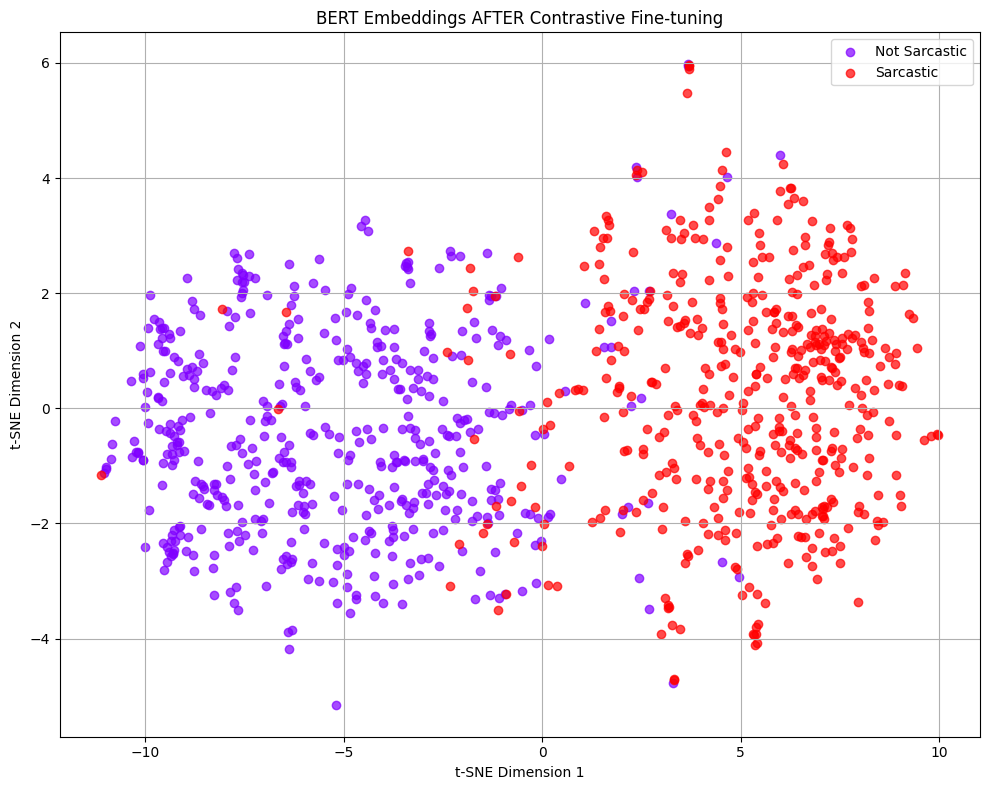

--- Embedding Visualization Finished ---


In [23]:
"""
Sarcasm Detection with Contrastive Fine-tuning and Visualization

This script demonstrates sarcasm detection using a combination of:
1. BERT embeddings fine-tuned with contrastive learning (Triplet Loss).
2. Linguistic features.
3. TF-IDF features.
It also includes t-SNE visualization of BERT embeddings before and after
contrastive fine-tuning to show the effect on class separability.
"""

# --- Essential Imports ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import random
import time
from collections import defaultdict

# --- Visualization Imports ---
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 32
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

# Contrastive Learning Config
CONTRASTIVE_EPOCHS = 3 # Number of epochs for fine-tuning
CONTRASTIVE_LR = 2e-5 # Learning rate for fine-tuning
CONTRASTIVE_MARGIN = 0.5 # Margin for TripletMarginLoss
PROJECTION_DIM = 256 # Optional: Dimension of projection head for contrastive learning

# Visualization Config
TSNE_PERPLEXITY = 30 # Typical value for t-SNE
TSNE_N_ITER = 300 # Number of iterations for t-SNE optimization
# Limit number of points for faster t-SNE? Set to None to use all test points
VISUALIZATION_SAMPLE_SIZE = 1000 # Reduce if t-SNE is too slow


df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str)
# Reset index just in case for proper indexing later
df = df.reset_index(drop=True)
print(f"Loaded data with {len(df)} samples.")
print(f"Class distribution:\n{df['is_sarcastic'].value_counts(normalize=True)}")

print("\nSplitting data into train/test sets...")
train_indices, test_indices = train_test_split(
    df.index,
    stratify=df['is_sarcastic'],
    random_state=RANDOM_STATE
)

# Create train/test dataframes using the indices
df_train = df.loc[train_indices].reset_index(drop=True)
df_test = df.loc[test_indices].reset_index(drop=True)
y_train = df_train['is_sarcastic'].values
y_test = df_test['is_sarcastic'].values

print(f"Train set size: {len(df_train)}, Test set size: {len(df_test)}")

# --- Load Tokenizer and BERT Model ---
print(f"\nLoading tokenizer and base BERT model: {BERT_MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
# Load the base model - we'll use this for "before" embeddings
bert_model_base = AutoModel.from_pretrained(BERT_MODEL_NAME)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_base.to(device)
print(f"Using device: {device}")

def get_bert_cls_embeddings(texts, model, tokenizer, device, max_length, batch_size):
    """Generates [CLS] token embeddings for a list of texts using the provided model."""
    all_cls_embeddings = []
    model.eval() # Ensure model is in eval mode
    num_samples = len(texts)
    print(f"  Generating embeddings for {num_samples} texts in batches of {batch_size}...")
    num_batches = (num_samples + batch_size - 1) // batch_size
    start_time = time.time()
    for i in range(0, num_samples, batch_size):
        batch_texts = texts[i:i+batch_size]
        # Tokenize batch, pad/truncate, move to device
        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            padding='max_length', # Use max_length padding for consistency
            truncation=True,
            max_length=max_length
        ).to(device)

        # Get model outputs without calculating gradients
        with torch.no_grad():
            outputs = model(**inputs) # Pass tokenized inputs directly

        # Extract the hidden state of the [CLS] token (first token) from the last layer
        cls_embeddings = outputs.last_hidden_state[:, 0, :]

        # Move embeddings to CPU and convert to numpy, append to list
        all_cls_embeddings.append(cls_embeddings.cpu().numpy())

        if (i // batch_size + 1) % 50 == 0 or (i // batch_size + 1) == num_batches: # Print progress
             progress = (i // batch_size + 1) / num_batches
             elapsed = time.time() - start_time
             eta = (elapsed / progress) * (1 - progress) if progress > 0 else 0
             print(f"    Processed batch {i // batch_size + 1}/{num_batches} ({progress*100:.1f}%) | ETA: {eta:.1f}s")

    print(f"  Finished generating embeddings in {time.time() - start_time:.2f}s.")
    # Combine embeddings from all batches
    if not all_cls_embeddings:
        # Get hidden size from model config if available
        hidden_size = model.config.hidden_size if hasattr(model, 'config') else 768
        return np.array([]).reshape(0, hidden_size) # Handle empty input
    return np.vstack(all_cls_embeddings)

# --- Generate Embeddings BEFORE Fine-tuning (for visualization) ---
print("\nGenerating BERT [CLS] embeddings BEFORE fine-tuning (for visualization)...")
# Use the base model loaded earlier
X_bert_test_before_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(),
    bert_model_base, # Use the original, non-fine-tuned model
    tokenizer,
    device,
    MAX_LENGTH,
    BATCH_SIZE
)
print("BERT [CLS] TEST embeddings BEFORE fine-tuning shape:", X_bert_test_before_ft.shape)


# --- Contrastive Learning Setup ---

class TripletSarcasmDataset(Dataset):
    """Dataset for generating triplets (anchor, positive, negative) for contrastive learning."""
    def __init__(self, dataframe, tokenizer, max_length):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = dataframe['is_sarcastic'].values
        self.texts = dataframe['clean_headline'].tolist()
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)
        self.unique_labels = sorted(list(self.label_to_indices.keys()))
        if len(self.unique_labels) < 2:
            raise ValueError("Contrastive learning requires at least two classes.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        anchor_text = self.texts[index]
        anchor_label = self.labels[index]

        # Select positive example (same label, different index)
        possible_positive_indices = [i for i in self.label_to_indices[anchor_label] if i != index]
        if not possible_positive_indices: # Handle cases where a class might have only one example
             # If no other positive exists, use the anchor itself (less ideal but prevents error)
             # Consider oversampling smaller classes if this happens frequently
            positive_index = index
        else:
            positive_index = random.choice(possible_positive_indices)
        positive_text = self.texts[positive_index]

        # Select negative example (different label)
        negative_label = random.choice([l for l in self.unique_labels if l != anchor_label])
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative_text = self.texts[negative_index]

        # Tokenize
        anchor_inputs = self.tokenizer(anchor_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        positive_inputs = self.tokenizer(positive_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        negative_inputs = self.tokenizer(negative_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        # Squeeze to remove the batch dimension added by tokenizer for single examples
        return {
            'anchor': {k: v.squeeze(0) for k, v in anchor_inputs.items()},
            'positive': {k: v.squeeze(0) for k, v in positive_inputs.items()},
            'negative': {k: v.squeeze(0) for k, v in negative_inputs.items()}
        }

class ContrastiveBERT(nn.Module):
    """Wrapper for BERT model with an optional projection head for contrastive learning."""
    def __init__(self, bert_model, projection_dim=None):
        super().__init__()
        self.bert = bert_model # This holds the actual BERT model to be fine-tuned
        self.projection_dim = projection_dim
        self.config = bert_model.config

        if self.projection_dim:
            # Simple linear projection head
            self.projection_head = nn.Sequential(
                nn.Linear(self.config.hidden_size, self.config.hidden_size), # Optional extra layer
                nn.ReLU(),
                nn.Linear(self.config.hidden_size, self.projection_dim)
            )
        else:
             self.projection_head = nn.Identity() # No projection

    def forward(self, input_ids, attention_mask, token_type_ids=None):
         # Pass input through BERT base model
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        # Get the [CLS] token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        # Pass CLS embedding through the projection head
        projected_embedding = self.projection_head(cls_embedding)
        return projected_embedding # Return the (potentially projected) embedding for contrastive loss


# --- Fine-tuning Function ---
def fine_tune_bert_contrastive(model, dataloader, optimizer, scheduler, loss_fn, device, epochs):
    """Performs contrastive fine-tuning of the BERT model."""
    model.train() # Set model to training mode
    start_time = time.time()
    total_batches = len(dataloader) * epochs

    print("\n--- Starting Contrastive Fine-tuning ---")
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")

        for i, batch in enumerate(dataloader):
            # Move batch components to device
            anchor_inputs = {k: v.to(device) for k, v in batch['anchor'].items()}
            positive_inputs = {k: v.to(device) for k, v in batch['positive'].items()}
            negative_inputs = {k: v.to(device) for k, v in batch['negative'].items()}

            # Zero gradients
            optimizer.zero_grad()

            # Get embeddings from the model
            # Note: We use the projection head output for the loss
            anchor_emb = model(**anchor_inputs)
            positive_emb = model(**positive_inputs)
            negative_emb = model(**negative_inputs)

            # Calculate triplet loss
            loss = loss_fn(anchor_emb, positive_emb, negative_emb)

            # Backpropagation
            loss.backward()
            optimizer.step()
            scheduler.step() # Update learning rate

            epoch_loss += loss.item()

            if (i + 1) % 50 == 0 or i == len(dataloader) - 1: # Print progress
                current_lr = scheduler.get_last_lr()[0]
                print(f"  Batch {i+1}/{len(dataloader)} | Loss: {loss.item():.4f} | LR: {current_lr:.2e}")

        avg_epoch_loss = epoch_loss / len(dataloader)
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} finished. Average Loss: {avg_epoch_loss:.4f} | Time: {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"--- Contrastive Fine-tuning Finished ---")
    print(f"Total training time: {total_time:.2f}s")


# --- Prepare for Contrastive Fine-tuning ---
print("\nPreparing for contrastive fine-tuning...")
# Create dataset and dataloader for the *training* data
train_triplet_dataset = TripletSarcasmDataset(df_train, tokenizer, MAX_LENGTH)
# Adjust batch size if memory issues arise
train_triplet_dataloader = DataLoader(train_triplet_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True) # Add num_workers/pin_memory if using GPU

contrastive_model = ContrastiveBERT(bert_model_base, projection_dim=PROJECTION_DIM).to(device)

# Define loss function and optimizer
triplet_loss_fn = nn.TripletMarginLoss(margin=CONTRASTIVE_MARGIN, p=2) # p=2 for Euclidean distance
optimizer = optim.AdamW(contrastive_model.parameters(), lr=CONTRASTIVE_LR)

# Define scheduler
total_steps = len(train_triplet_dataloader) * CONTRASTIVE_EPOCHS
# Add a small number of warmup steps (e.g., 10% of first epoch)
num_warmup_steps = int(0.1 * len(train_triplet_dataloader))
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=num_warmup_steps,
                                            num_training_steps=total_steps)

# --- Run Contrastive Fine-tuning ---
# This will modify the weights within contrastive_model.bert
fine_tune_bert_contrastive(contrastive_model, train_triplet_dataloader, optimizer, scheduler, triplet_loss_fn, device, CONTRASTIVE_EPOCHS)

fine_tuned_base_bert_model = contrastive_model.bert
fine_tuned_base_bert_model.eval() # Set to evaluation mode
fine_tuned_base_bert_model.to(device) # Ensure it's on the right device


# --- Generate Embeddings AFTER Fine-tuning ---
print("\nGenerating Fine-tuned BERT [CLS] embeddings for TRAIN set...")
X_bert_train_after_ft = get_bert_cls_embeddings(
    df_train['clean_headline'].tolist(),
    fine_tuned_base_bert_model, # Use the fine-tuned base model
    tokenizer,
    device,
    MAX_LENGTH,
    BATCH_SIZE
)
print("Fine-tuned BERT [CLS] TRAIN embeddings shape:", X_bert_train_after_ft.shape)

print("\nGenerating Fine-tuned BERT [CLS] embeddings for TEST set...")
X_bert_test_after_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(),
    fine_tuned_base_bert_model, # Use the same fine-tuned base model
    tokenizer,
    device,
    MAX_LENGTH,
    BATCH_SIZE
)
print("Fine-tuned BERT [CLS] TEST embeddings shape:", X_bert_test_after_ft.shape)


# --- Visualization Section ---
print("\n--- Starting Embedding Visualization (t-SNE) ---")
print("Note: t-SNE can be computationally intensive.")

def plot_embeddings(embeddings_2d, labels, title):
    """Plots 2D embeddings with labels.
       Assumes embeddings_2d and labels are already aligned and potentially sampled."""
    plt.figure(figsize=(10, 8))
    unique_labels = sorted(np.unique(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'} # Assuming 0/1 labels

    for label, color in zip(unique_labels, colors):
        indices = np.where(labels == label)
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                    c=[color], # Scatter expects a list of colors even for one color
                    label=label_map.get(label, f"Class {label}"),
                    alpha=0.7)

    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show() # Use plt.show() for interactive display


# Prepare data for t-SNE (use a subset if specified) - CORRECTED SAMPLING
if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_test):
    print(f"Using a random sample of {VISUALIZATION_SAMPLE_SIZE} points for t-SNE.")
    # Ensure sample size is not larger than the available data
    actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_test))
    if actual_sample_size != VISUALIZATION_SAMPLE_SIZE:
        print(f"Warning: Requested sample size {VISUALIZATION_SAMPLE_SIZE} > available data {len(y_test)}. Using {actual_sample_size}.")
    sample_indices = np.random.choice(len(y_test), actual_sample_size, replace=False)

    # Sample high-dimensional embeddings AND labels using the same indices
    embeddings_to_tsne_before = X_bert_test_before_ft[sample_indices]
    embeddings_to_tsne_after = X_bert_test_after_ft[sample_indices]
    labels_for_plot = y_test[sample_indices] # Sample the labels!
else:
    print("Using all test points for t-SNE.")
    # No sampling needed
    embeddings_to_tsne_before = X_bert_test_before_ft
    embeddings_to_tsne_after = X_bert_test_after_ft
    labels_for_plot = y_test # Use all labels


# Apply t-SNE to "BEFORE" embeddings
print("\nRunning t-SNE on embeddings BEFORE fine-tuning...")
tsne_before = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1)
# Apply t-SNE to the (potentially sampled) high-dimensional embeddings
embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before)
print("t-SNE finished for 'before' embeddings.")
# Call plotting function with the 2D embeddings and the corresponding (potentially sampled) labels
plot_embeddings(embeddings_2d_before, labels_for_plot, "BERT Embeddings BEFORE Contrastive Fine-tuning")


# Apply t-SNE to "AFTER" embeddings
print("\nRunning t-SNE on embeddings AFTER fine-tuning...")
tsne_after = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1)
# Apply t-SNE to the (potentially sampled) high-dimensional embeddings
embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after)
print("t-SNE finished for 'after' embeddings.")
# Call plotting function with the 2D embeddings and the corresponding (potentially sampled) labels
plot_embeddings(embeddings_2d_after, labels_for_plot, "BERT Embeddings AFTER Contrastive Fine-tuning")

print("--- Embedding Visualization Finished ---")


Extracting linguistic features...
Linguistic TRAIN features shape: (21464, 17)
Linguistic TEST features shape: (7155, 17)

Combining Fine-tuned BERT [CLS] and linguistic features...
Combined BERT+Ling TRAIN shape: (21464, 785)
Combined BERT+Ling TEST shape: (7155, 785)

Scaling combined BERT+Ling features...
Scaled Combined BERT+Ling TRAIN features shape (sparse): (21464, 785)
Scaled Combined BERT+Ling TEST features shape (sparse): (7155, 785)

Generating TF-IDF features...
TF-IDF Train shape: (21464, 23183)
TF-IDF Test shape: (7155, 23183)

Combining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...
Final Combined Train shape: (21464, 23968)
Final Combined Test shape: (7155, 23968)

--- Training Downstream Classifier (Logistic Regression) ---
Training Logistic Regression model...
Training finished in 11.02s

Evaluating Logistic Regression model on the test set...
Evaluation finished in 0.03s

--- Classification Results ---

Classification Report:
               precision    recall

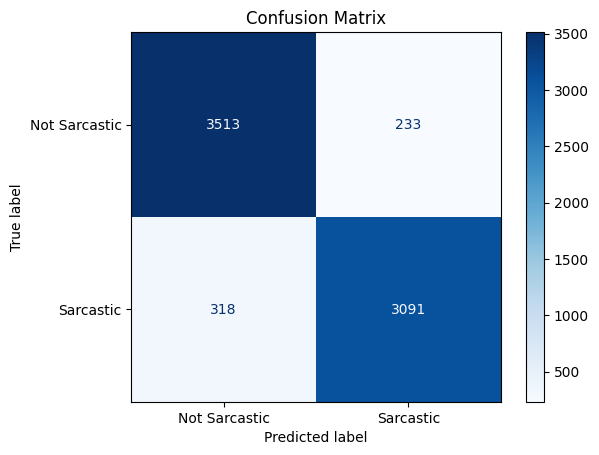


Macro F1 Score: 0.9227
Weighted F1 Score: 0.9229

--- Script Finished ---


In [26]:
# --- Feature Generation (using fine-tuned BERT for downstream task) ---

# 1. Linguistic Features for TRAIN and TEST sets
print("\nExtracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']

# Ensure all ling features exist, fill missing with 0 or mean if appropriate
for col in ling_feature_names:
    if col not in df_train.columns:
        print(f"Warning: Linguistic feature '{col}' not found in training data. Filling with 0.")
        df_train[col] = 0
    if col not in df_test.columns:
        print(f"Warning: Linguistic feature '{col}' not found in test data. Filling with 0.")
        df_test[col] = 0

# Handle potential NaN values that might arise if features weren't generated correctly
df_train[ling_feature_names] = df_train[ling_feature_names].fillna(0)
df_test[ling_feature_names] = df_test[ling_feature_names].fillna(0)

X_ling_train = df_train[ling_feature_names].values
X_ling_test = df_test[ling_feature_names].values
print("Linguistic TRAIN features shape:", X_ling_train.shape)
print("Linguistic TEST features shape:", X_ling_test.shape)

# 2. Combine Fine-tuned BERT [CLS] + Linguistic Features (Dense) for TRAIN and TEST
print("\nCombining Fine-tuned BERT [CLS] and linguistic features...")
# Use the 'after_ft' embeddings generated earlier
X_gling_train = np.hstack([X_bert_train_after_ft, X_ling_train])
X_gling_test = np.hstack([X_bert_test_after_ft, X_ling_test])
print("Combined BERT+Ling TRAIN shape:", X_gling_train.shape)
print("Combined BERT+Ling TEST shape:", X_gling_test.shape)

# --- Feature Scaling (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nScaling combined BERT+Ling features...")
# Scale only the combined dense features before adding sparse TF-IDF
scaler = StandardScaler()
X_gling_train_scaled = scaler.fit_transform(X_gling_train) # Fit ONLY on training data
X_gling_test_scaled = scaler.transform(X_gling_test)   # Transform test data

# Convert scaled dense features to sparse format for hstack
X_train_sparse_scaled_gling = csr_matrix(X_gling_train_scaled)
X_test_sparse_scaled_gling = csr_matrix(X_gling_test_scaled)
print("Scaled Combined BERT+Ling TRAIN features shape (sparse):", X_train_sparse_scaled_gling.shape)
print("Scaled Combined BERT+Ling TEST features shape (sparse):", X_test_sparse_scaled_gling.shape)

# --- TF-IDF Features (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nGenerating TF-IDF features...")
tfidf = TfidfVectorizer()

# Fit TF-IDF ONLY on the training text data
X_train_tfidf = tfidf.fit_transform(df_train['clean_headline'])
# Transform the test text data using the fitted TF-IDF vectorizer
X_test_tfidf = tfidf.transform(df_test['clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# --- Final Feature Combination ---
print("\nCombining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...")
# Combine TF-IDF + Scaled(BERT+Ling) features using hstack
X_train_combined = hstack([X_train_tfidf, X_train_sparse_scaled_gling])
X_test_combined = hstack([X_test_tfidf, X_test_sparse_scaled_gling])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)

# --- Logistic Regression Model ---
print("\n--- Training Downstream Classifier (Logistic Regression) ---")

lr = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=RANDOM_STATE)
print("Training Logistic Regression model...")
train_start_time = time.time()
lr.fit(X_train_combined, y_train)
print(f"Training finished in {time.time() - train_start_time:.2f}s")

print("\nEvaluating Logistic Regression model on the test set...")
eval_start_time = time.time()
y_pred = lr.predict(X_test_combined)
y_pred_proba = lr.predict_proba(X_test_combined)[:, 1] # Get probabilities for class 1 (sarcastic)
print(f"Evaluation finished in {time.time() - eval_start_time:.2f}s")

print("\n--- Classification Results ---")
print("\nClassification Report:")
# Use zero_division=0 to handle cases where a class might have no predictions/support
print(classification_report(y_test, y_pred, target_names=['Not Sarcastic', 'Sarcastic'], zero_division=0))

print("\nConfusion Matrix:")
try:
    from sklearn.metrics import ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
except ImportError:
    print("Confusion Matrix (sklearn.metrics.ConfusionMatrixDisplay not available):")
    print(confusion_matrix(y_test, y_pred, labels=lr.classes_))


print(f"\nMacro F1 Score: {f1_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")

print("\n--- Script Finished ---")

## 3 Epochs

In [ ]:
# -*- coding: utf-8 -*-
"""
Sarcasm Detection with Contrastive Fine-tuning and Visualization

This script demonstrates sarcasm detection using a combination of:
1. BERT embeddings fine-tuned with contrastive learning (Triplet Loss).
2. Linguistic features.
3. TF-IDF features.
It also includes t-SNE visualization of BERT embeddings before and after
contrastive fine-tuning to show the effect on class separability.
"""

# --- Essential Imports ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import random
import time
from collections import defaultdict

# --- Visualization Imports ---
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- Configuration ---
BERT_MODEL_NAME = 'bert-base-uncased' # Standard BERT model
MAX_LENGTH = 128  # Max sequence length for BERT tokenizer
BATCH_SIZE = 32  # Batch size for embedding generation AND contrastive training
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

# Contrastive Learning Config
CONTRASTIVE_EPOCHS = 5 # Number of epochs for fine-tuning
CONTRASTIVE_LR = 2e-5 # Learning rate for fine-tuning
CONTRASTIVE_MARGIN = 0.5 # Margin for TripletMarginLoss
PROJECTION_DIM = 256 # Optional: Dimension of projection head for contrastive learning

# Visualization Config
TSNE_PERPLEXITY = 30 # Typical value for t-SNE
TSNE_N_ITER = 300 # Number of iterations for t-SNE optimization
# Limit number of points for faster t-SNE? Set to None to use all test points
VISUALIZATION_SAMPLE_SIZE = 1000 # Reduce if t-SNE is too slow



df['is_sarcastic'] = df['is_sarcastic'].astype(int)
df['clean_headline'] = df['clean_headline'].astype(str)
# Reset index just in case for proper indexing later
df = df.reset_index(drop=True)
print(f"Loaded data with {len(df)} samples.")
print(f"Class distribution:\n{df['is_sarcastic'].value_counts(normalize=True)}")
# --- End Example Data ---


# --- Split Data FIRST ---
# We need the training indices to prepare the contrastive learning dataset
print("\nSplitting data into train/test sets...")
train_indices, test_indices = train_test_split(
    df.index,
    stratify=df['is_sarcastic'],
    random_state=RANDOM_STATE
)

# Create train/test dataframes using the indices
df_train = df.loc[train_indices].reset_index(drop=True)
df_test = df.loc[test_indices].reset_index(drop=True)
y_train = df_train['is_sarcastic'].values
y_test = df_test['is_sarcastic'].values

print(f"Train set size: {len(df_train)}, Test set size: {len(df_test)}")

# --- Load Tokenizer and BERT Model ---
print(f"\nLoading tokenizer and base BERT model: {BERT_MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
# Load the base model - we'll use this for "before" embeddings
bert_model_base = AutoModel.from_pretrained(BERT_MODEL_NAME)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_base.to(device)
print(f"Using device: {device}")


# --- Function to Get BERT [CLS] Embeddings ---
# This function will be used for both 'before' and 'after' embeddings
def get_bert_cls_embeddings(texts, model, tokenizer, device, max_length, batch_size):
    """Generates [CLS] token embeddings for a list of texts using the provided model."""
    all_cls_embeddings = []
    model.eval() # Ensure model is in eval mode
    num_samples = len(texts)
    print(f"  Generating embeddings for {num_samples} texts in batches of {batch_size}...")
    num_batches = (num_samples + batch_size - 1) // batch_size
    start_time = time.time()
    for i in range(0, num_samples, batch_size):
        batch_texts = texts[i:i+batch_size]
        # Tokenize batch, pad/truncate, move to device
        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            padding='max_length', # Use max_length padding for consistency
            truncation=True,
            max_length=max_length
        ).to(device)

        # Get model outputs without calculating gradients
        with torch.no_grad():
            outputs = model(**inputs) # Pass tokenized inputs directly

        # Extract the hidden state of the [CLS] token (first token) from the last layer
        cls_embeddings = outputs.last_hidden_state[:, 0, :]

        # Move embeddings to CPU and convert to numpy, append to list
        all_cls_embeddings.append(cls_embeddings.cpu().numpy())

        if (i // batch_size + 1) % 50 == 0 or (i // batch_size + 1) == num_batches: # Print progress
             progress = (i // batch_size + 1) / num_batches
             elapsed = time.time() - start_time
             eta = (elapsed / progress) * (1 - progress) if progress > 0 else 0
             print(f"    Processed batch {i // batch_size + 1}/{num_batches} ({progress*100:.1f}%) | ETA: {eta:.1f}s")

    print(f"  Finished generating embeddings in {time.time() - start_time:.2f}s.")
    # Combine embeddings from all batches
    if not all_cls_embeddings:
        # Get hidden size from model config if available
        hidden_size = model.config.hidden_size if hasattr(model, 'config') else 768
        return np.array([]).reshape(0, hidden_size) # Handle empty input
    return np.vstack(all_cls_embeddings)

# --- Generate Embeddings BEFORE Fine-tuning (for visualization) ---
print("\nGenerating BERT [CLS] embeddings BEFORE fine-tuning (for visualization)...")
# Use the base model loaded earlier
X_bert_test_before_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(),
    bert_model_base, # Use the original, non-fine-tuned model
    tokenizer,
    device,
    MAX_LENGTH,
    BATCH_SIZE
)
print("BERT [CLS] TEST embeddings BEFORE fine-tuning shape:", X_bert_test_before_ft.shape)


# --- Contrastive Learning Setup ---

class TripletSarcasmDataset(Dataset):
    """Dataset for generating triplets (anchor, positive, negative) for contrastive learning."""
    def __init__(self, dataframe, tokenizer, max_length):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = dataframe['is_sarcastic'].values
        self.texts = dataframe['clean_headline'].tolist()
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)
        self.unique_labels = sorted(list(self.label_to_indices.keys()))
        if len(self.unique_labels) < 2:
            raise ValueError("Contrastive learning requires at least two classes.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        anchor_text = self.texts[index]
        anchor_label = self.labels[index]

        # Select positive example (same label, different index)
        possible_positive_indices = [i for i in self.label_to_indices[anchor_label] if i != index]
        if not possible_positive_indices: # Handle cases where a class might have only one example
             # If no other positive exists, use the anchor itself (less ideal but prevents error)
             # Consider oversampling smaller classes if this happens frequently
            positive_index = index
        else:
            positive_index = random.choice(possible_positive_indices)
        positive_text = self.texts[positive_index]

        # Select negative example (different label)
        negative_label = random.choice([l for l in self.unique_labels if l != anchor_label])
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative_text = self.texts[negative_index]

        # Tokenize
        anchor_inputs = self.tokenizer(anchor_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        positive_inputs = self.tokenizer(positive_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        negative_inputs = self.tokenizer(negative_text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        # Squeeze to remove the batch dimension added by tokenizer for single examples
        return {
            'anchor': {k: v.squeeze(0) for k, v in anchor_inputs.items()},
            'positive': {k: v.squeeze(0) for k, v in positive_inputs.items()},
            'negative': {k: v.squeeze(0) for k, v in negative_inputs.items()}
        }

class ContrastiveBERT(nn.Module):
    """Wrapper for BERT model with an optional projection head for contrastive learning."""
    def __init__(self, bert_model, projection_dim=None):
        super().__init__()
        self.bert = bert_model # This holds the actual BERT model to be fine-tuned
        self.projection_dim = projection_dim
        self.config = bert_model.config

        if self.projection_dim:
            # Simple linear projection head
            self.projection_head = nn.Sequential(
                nn.Linear(self.config.hidden_size, self.config.hidden_size), # Optional extra layer
                nn.ReLU(),
                nn.Linear(self.config.hidden_size, self.projection_dim)
            )
        else:
             self.projection_head = nn.Identity() # No projection

    def forward(self, input_ids, attention_mask, token_type_ids=None):
         # Pass input through BERT base model
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        # Get the [CLS] token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        # Pass CLS embedding through the projection head
        projected_embedding = self.projection_head(cls_embedding)
        return projected_embedding # Return the (potentially projected) embedding for contrastive loss


# --- Fine-tuning Function ---
def fine_tune_bert_contrastive(model, dataloader, optimizer, scheduler, loss_fn, device, epochs):
    """Performs contrastive fine-tuning of the BERT model."""
    model.train() # Set model to training mode
    start_time = time.time()
    total_batches = len(dataloader) * epochs

    print("\n--- Starting Contrastive Fine-tuning ---")
    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")

        for i, batch in enumerate(dataloader):
            # Move batch components to device
            anchor_inputs = {k: v.to(device) for k, v in batch['anchor'].items()}
            positive_inputs = {k: v.to(device) for k, v in batch['positive'].items()}
            negative_inputs = {k: v.to(device) for k, v in batch['negative'].items()}

            # Zero gradients
            optimizer.zero_grad()

            # Get embeddings from the model
            # Note: We use the projection head output for the loss
            anchor_emb = model(**anchor_inputs)
            positive_emb = model(**positive_inputs)
            negative_emb = model(**negative_inputs)

            # Calculate triplet loss
            loss = loss_fn(anchor_emb, positive_emb, negative_emb)

            # Backpropagation
            loss.backward()
            # Optional: Gradient clipping to prevent exploding gradients
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step() # Update learning rate

            epoch_loss += loss.item()

            if (i + 1) % 50 == 0 or i == len(dataloader) - 1: # Print progress
                current_lr = scheduler.get_last_lr()[0]
                print(f"  Batch {i+1}/{len(dataloader)} | Loss: {loss.item():.4f} | LR: {current_lr:.2e}")

        avg_epoch_loss = epoch_loss / len(dataloader)
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} finished. Average Loss: {avg_epoch_loss:.4f} | Time: {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"--- Contrastive Fine-tuning Finished ---")
    print(f"Total training time: {total_time:.2f}s")


# --- Prepare for Contrastive Fine-tuning ---
print("\nPreparing for contrastive fine-tuning...")
# Create dataset and dataloader for the *training* data
train_triplet_dataset = TripletSarcasmDataset(df_train, tokenizer, MAX_LENGTH)
# Adjust batch size if memory issues arise
train_triplet_dataloader = DataLoader(train_triplet_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True) # Add num_workers/pin_memory if using GPU

# Instantiate the contrastive model wrapper
# IMPORTANT: Pass the 'bert_model_base' which holds the pre-trained weights
contrastive_model = ContrastiveBERT(bert_model_base, projection_dim=PROJECTION_DIM).to(device)

# Define loss function and optimizer
triplet_loss_fn = nn.TripletMarginLoss(margin=CONTRASTIVE_MARGIN, p=2) # p=2 for Euclidean distance
optimizer = optim.AdamW(contrastive_model.parameters(), lr=CONTRASTIVE_LR)

# Define scheduler
total_steps = len(train_triplet_dataloader) * CONTRASTIVE_EPOCHS
# Add a small number of warmup steps (e.g., 10% of first epoch)
num_warmup_steps = int(0.1 * len(train_triplet_dataloader))
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=num_warmup_steps,
                                            num_training_steps=total_steps)

# --- Run Contrastive Fine-tuning ---
# This will modify the weights within contrastive_model.bert
fine_tune_bert_contrastive(contrastive_model, train_triplet_dataloader, optimizer, scheduler, triplet_loss_fn, device, CONTRASTIVE_EPOCHS)

# --- IMPORTANT: Use the fine-tuned BASE BERT model for embedding extraction ---
# Access the fine-tuned BERT model from the wrapper
fine_tuned_base_bert_model = contrastive_model.bert
fine_tuned_base_bert_model.eval() # Set to evaluation mode
fine_tuned_base_bert_model.to(device) # Ensure it's on the right device


# --- Generate Embeddings AFTER Fine-tuning ---
print("\nGenerating Fine-tuned BERT [CLS] embeddings for TRAIN set...")
X_bert_train_after_ft = get_bert_cls_embeddings(
    df_train['clean_headline'].tolist(),
    fine_tuned_base_bert_model, # Use the fine-tuned base model
    tokenizer,
    device,
    MAX_LENGTH,
    BATCH_SIZE
)
print("Fine-tuned BERT [CLS] TRAIN embeddings shape:", X_bert_train_after_ft.shape)

print("\nGenerating Fine-tuned BERT [CLS] embeddings for TEST set...")
X_bert_test_after_ft = get_bert_cls_embeddings(
    df_test['clean_headline'].tolist(),
    fine_tuned_base_bert_model, # Use the same fine-tuned base model
    tokenizer,
    device,
    MAX_LENGTH,
    BATCH_SIZE
)
print("Fine-tuned BERT [CLS] TEST embeddings shape:", X_bert_test_after_ft.shape)


# --- Visualization Section ---
print("\n--- Starting Embedding Visualization (t-SNE) ---")
print("Note: t-SNE can be computationally intensive.")

# CORRECTED plot_embeddings function (no sampling inside)
def plot_embeddings(embeddings_2d, labels, title):
    """Plots 2D embeddings with labels.
       Assumes embeddings_2d and labels are already aligned and potentially sampled."""
    plt.figure(figsize=(10, 8))
    unique_labels = sorted(np.unique(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_map = {0: 'Not Sarcastic', 1: 'Sarcastic'} # Assuming 0/1 labels

    for label, color in zip(unique_labels, colors):
        indices = np.where(labels == label)
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                    c=[color], # Scatter expects a list of colors even for one color
                    label=label_map.get(label, f"Class {label}"),
                    alpha=0.7)

    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show() # Use plt.show() for interactive display


# Prepare data for t-SNE (use a subset if specified) - CORRECTED SAMPLING
if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < len(y_test):
    print(f"Using a random sample of {VISUALIZATION_SAMPLE_SIZE} points for t-SNE.")
    # Ensure sample size is not larger than the available data
    actual_sample_size = min(VISUALIZATION_SAMPLE_SIZE, len(y_test))
    if actual_sample_size != VISUALIZATION_SAMPLE_SIZE:
        print(f"Warning: Requested sample size {VISUALIZATION_SAMPLE_SIZE} > available data {len(y_test)}. Using {actual_sample_size}.")
    sample_indices = np.random.choice(len(y_test), actual_sample_size, replace=False)

    # Sample high-dimensional embeddings AND labels using the same indices
    embeddings_to_tsne_before = X_bert_test_before_ft[sample_indices]
    embeddings_to_tsne_after = X_bert_test_after_ft[sample_indices]
    labels_for_plot = y_test[sample_indices] # Sample the labels!
else:
    print("Using all test points for t-SNE.")
    # No sampling needed
    embeddings_to_tsne_before = X_bert_test_before_ft
    embeddings_to_tsne_after = X_bert_test_after_ft
    labels_for_plot = y_test # Use all labels


# Apply t-SNE to "BEFORE" embeddings
print("\nRunning t-SNE on embeddings BEFORE fine-tuning...")
tsne_before = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1)
# Apply t-SNE to the (potentially sampled) high-dimensional embeddings
embeddings_2d_before = tsne_before.fit_transform(embeddings_to_tsne_before)
print("t-SNE finished for 'before' embeddings.")
# Call plotting function with the 2D embeddings and the corresponding (potentially sampled) labels
plot_embeddings(embeddings_2d_before, labels_for_plot, "BERT Embeddings BEFORE Contrastive Fine-tuning")


# Apply t-SNE to "AFTER" embeddings
print("\nRunning t-SNE on embeddings AFTER fine-tuning...")
tsne_after = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_N_ITER, verbose=1)
# Apply t-SNE to the (potentially sampled) high-dimensional embeddings
embeddings_2d_after = tsne_after.fit_transform(embeddings_to_tsne_after)
print("t-SNE finished for 'after' embeddings.")
# Call plotting function with the 2D embeddings and the corresponding (potentially sampled) labels
plot_embeddings(embeddings_2d_after, labels_for_plot, "BERT Embeddings AFTER Contrastive Fine-tuning")

print("--- Embedding Visualization Finished ---")

Loaded data with 28619 samples.
Class distribution:
is_sarcastic
0    0.523603
1    0.476397
Name: proportion, dtype: float64

Splitting data into train/test sets...
Train set size: 21464, Test set size: 7155

Loading tokenizer and base BERT model: bert-base-uncased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Using device: cuda

Generating BERT [CLS] embeddings BEFORE fine-tuning (for visualization)...
  Generating embeddings for 7155 texts in batches of 32...
    Processed batch 50/224 (22.3%) | ETA: 32.8s
    Processed batch 100/224 (44.6%) | ETA: 22.9s
    Processed batch 150/224 (67.0%) | ETA: 13.7s
    Processed batch 200/224 (89.3%) | ETA: 4.4s
    Processed batch 224/224 (100.0%) | ETA: 0.0s
  Finished generating embeddings in 41.30s.
BERT [CLS] TEST embeddings BEFORE fine-tuning shape: (7155, 768)

Preparing for contrastive fine-tuning...

--- Starting Contrastive Fine-tuning ---

Epoch 1/5
  Batch 50/671 | Loss: 0.3084 | LR: 1.49e-05
  Batch 100/671 | Loss: 0.2117 | LR: 1.98e-05
  Batch 150/671 | Loss: 0.0859 | LR: 1.95e-05
  Batch 200/671 | Loss: 0.1191 | LR: 1.92e-05
  Batch 250/671 | Loss: 0.2226 | LR: 1.89e-05
  Batch 300/671 | Loss: 0.1577 | LR: 1.86e-05
  Batch 350/671 | Loss: 0.1376 | LR: 1.83e-05
  Batch 400/671 | Loss: 0.1742 | LR: 1.80e-05
  Batch 450/671 | Loss: 0.1917 |

In [ ]:
# --- Feature Generation (using fine-tuned BERT for downstream task) ---

# 1. Linguistic Features for TRAIN and TEST sets
print("\nExtracting linguistic features...")
ling_feature_names = ['text_length', 'noun_count', 'verb_count', 'adj_count', 'adv_count', 'dale_chall_score',
                      'sentiment_score', 'char_count', 'capital_char_count', 'capital_word_count',
                      'stopword_count', 'stopwords_vs_words', 'contrastive_marker', 'entropy',
                      'lexical_diversity', 'sentiment_incongruity', 'difficult_word_count']

# Ensure all ling features exist, fill missing with 0 or mean if appropriate
for col in ling_feature_names:
    if col not in df_train.columns:
        print(f"Warning: Linguistic feature '{col}' not found in training data. Filling with 0.")
        df_train[col] = 0
    if col not in df_test.columns:
        print(f"Warning: Linguistic feature '{col}' not found in test data. Filling with 0.")
        df_test[col] = 0
    # Optional: Impute with mean/median from training data if more appropriate than 0
    # if df_train[col].isnull().any():
    #     mean_val = df_train[col].mean() # Or median()
    #     df_train[col] = df_train[col].fillna(mean_val)
    #     df_test[col] = df_test[col].fillna(mean_val) # Use train mean for test

# Handle potential NaN values that might arise if features weren't generated correctly
df_train[ling_feature_names] = df_train[ling_feature_names].fillna(0)
df_test[ling_feature_names] = df_test[ling_feature_names].fillna(0)

X_ling_train = df_train[ling_feature_names].values
X_ling_test = df_test[ling_feature_names].values
print("Linguistic TRAIN features shape:", X_ling_train.shape)
print("Linguistic TEST features shape:", X_ling_test.shape)

# 2. Combine Fine-tuned BERT [CLS] + Linguistic Features (Dense) for TRAIN and TEST
print("\nCombining Fine-tuned BERT [CLS] and linguistic features...")
# Use the 'after_ft' embeddings generated earlier
X_gling_train = np.hstack([X_bert_train_after_ft, X_ling_train])
X_gling_test = np.hstack([X_bert_test_after_ft, X_ling_test])
print("Combined BERT+Ling TRAIN shape:", X_gling_train.shape)
print("Combined BERT+Ling TEST shape:", X_gling_test.shape)

# --- Feature Scaling (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nScaling combined BERT+Ling features...")
# Scale only the combined dense features before adding sparse TF-IDF
scaler = StandardScaler()
X_gling_train_scaled = scaler.fit_transform(X_gling_train) # Fit ONLY on training data
X_gling_test_scaled = scaler.transform(X_gling_test)   # Transform test data

# Convert scaled dense features to sparse format for hstack
X_train_sparse_scaled_gling = csr_matrix(X_gling_train_scaled)
X_test_sparse_scaled_gling = csr_matrix(X_gling_test_scaled)
print("Scaled Combined BERT+Ling TRAIN features shape (sparse):", X_train_sparse_scaled_gling.shape)
print("Scaled Combined BERT+Ling TEST features shape (sparse):", X_test_sparse_scaled_gling.shape)

# --- TF-IDF Features (Fit on TRAIN, Transform TRAIN and TEST) ---
print("\nGenerating TF-IDF features...")
# Consider limiting features or using min/max df
tfidf = TfidfVectorizer(max_features=5000, min_df=3, max_df=0.9)

# Fit TF-IDF ONLY on the training text data
X_train_tfidf = tfidf.fit_transform(df_train['clean_headline'])
# Transform the test text data using the fitted TF-IDF vectorizer
X_test_tfidf = tfidf.transform(df_test['clean_headline'])
print("TF-IDF Train shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)

# --- Final Feature Combination ---
print("\nCombining TF-IDF and Scaled (Fine-tuned BERT+Ling) features...")
# Combine TF-IDF + Scaled(BERT+Ling) features using hstack
X_train_combined = hstack([X_train_tfidf, X_train_sparse_scaled_gling])
X_test_combined = hstack([X_test_tfidf, X_test_sparse_scaled_gling])
print("Final Combined Train shape:", X_train_combined.shape)
print("Final Combined Test shape:", X_test_combined.shape)

# --- Logistic Regression Model ---
print("\n--- Training Downstream Classifier (Logistic Regression) ---")
# Use a solver suitable for potentially large sparse data like liblinear or saga
# Increased max_iter substantially for potentially harder convergence with high dimensions
# Added C for regularization strength (smaller C = stronger regularization)
lr = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=RANDOM_STATE, solver='liblinear', C=1.0, tol=1e-4)
print("Training Logistic Regression model...")
train_start_time = time.time()
lr.fit(X_train_combined, y_train)
print(f"Training finished in {time.time() - train_start_time:.2f}s")

print("\nEvaluating Logistic Regression model on the test set...")
eval_start_time = time.time()
y_pred = lr.predict(X_test_combined)
y_pred_proba = lr.predict_proba(X_test_combined)[:, 1] # Get probabilities for class 1 (sarcastic)
print(f"Evaluation finished in {time.time() - eval_start_time:.2f}s")

print("\n--- Classification Results ---")
print("\nClassification Report:")
# Use zero_division=0 to handle cases where a class might have no predictions/support
print(classification_report(y_test, y_pred, target_names=['Not Sarcastic', 'Sarcastic'], zero_division=0))

print("\nConfusion Matrix:")
# Plotting the confusion matrix might be nice for an exhibition
try:
    from sklearn.metrics import ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
except ImportError:
    print("Confusion Matrix (sklearn.metrics.ConfusionMatrixDisplay not available):")
    print(confusion_matrix(y_test, y_pred, labels=lr.classes_))


print(f"\nMacro F1 Score: {f1_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")

# You could also calculate AUC if needed
# from sklearn.metrics import roc_auc_score
# try:
#     auc = roc_auc_score(y_test, y_pred_proba)
#     print(f"AUC Score: {auc:.4f}")
# except ValueError:
#     print("AUC score cannot be calculated (might need probabilities or only one class present in y_true).")


print("\n--- Script Finished ---")